### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
!ls -ltrh /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome*

-rwxrwxr-x 1 ilibarra ilibarra 1.8M Jun 10 10:55 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_0.pth
-rwxrwxr-x 1 ilibarra ilibarra 1.8M Jun 10 10:55 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_1.pth
-rw-rw-r-- 1 ilibarra ilibarra 1.8M Jun 11 00:03 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_0_obs480.pth
-rw-rw-r-- 1 ilibarra ilibarra 1.8M Jun 11 00:03 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_1_obs480.pth
-rw-rw-r-- 1 ilibarra ilibarra 2.7M Jun 11 00:19 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_0_obs912.pth
-rw-rw-r-- 1 ilibarra ilibarra 2.8M Jun 11 00:19 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_1_obs912.pth
-rw-rw-r-- 1 ilibarra ilibarra 9.8M 

In [4]:
import torch
import mubind as mb
import scanpy as sc

In [5]:
# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = "pancreas_multiome_use_logdynamic_%i_obs4148.pth" % use_logdynamic
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

pancreas_multiome_use_logdynamic_0_obs4148.pth
pancreas_multiome_use_logdynamic_1_obs4148.pth


In [6]:
!ls -ltrh /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/atac_train*

-rw-rw-r-- 1 ilibarra ilibarra 24M Jun 11 20:19 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/atac_train.h5ad


In [7]:
ad = sc.read_h5ad("atac_train.h5ad")
rna_sample = sc.read_h5ad("rna_sample_train.h5ad")

In [8]:
import pickle


train = pickle.load(open("train_dataloader.pkl", "rb"))

In [9]:
%load_ext line_profiler

In [10]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome()  # data_directory='../../../annotations/scatac')

True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad


True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad


In [11]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [12]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [13]:
import matplotlib.pyplot as plt

In [14]:
cell_type_key = "celltype"

Graph Layer |  False
True
3
order None
0 out of 288...
break


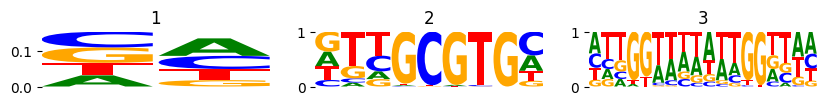

Graph Layer |  True
True
3
order None
0 out of 288...
break


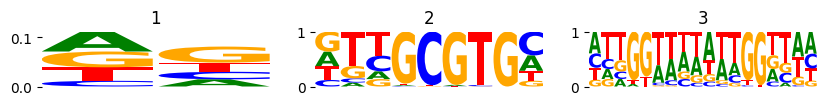

In [15]:
for optimize_log_dynamic in model_by_logdynamic:
    print("Graph Layer | ", optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # print(optimize_log_dynamic)
    from matplotlib import rcParams

    rcParams["figure.figsize"] = 10, 5
    rcParams["figure.dpi"] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4)  #  log=True)
    plt.show()

True


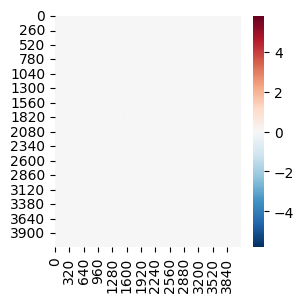

In [16]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns

    mb.pl.set_rcParams({"figure.figsize": [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap="RdBu_r")
    plt.show()

In [17]:
model = model_by_logdynamic[1]

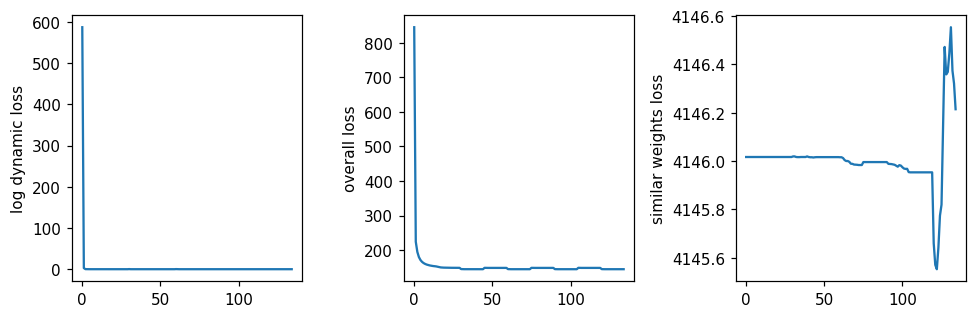

In [18]:
mb.pl.set_rcParams({"figure.figsize": [12, 3], "figure.dpi": 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel("log dynamic loss")
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel("overall loss")
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel("similar weights loss")
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import numpy as np

False
True


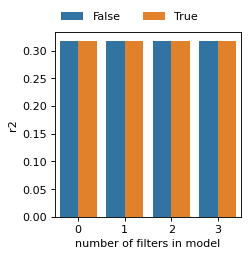

In [20]:
rcParams["figure.figsize"] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns

    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=["r2"]).reset_index()
        r2["opt_log_dynamic"] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams["figure.figsize"] = 3, 3
    rcParams["figure.dpi"] = 80
    ax = sns.barplot(
        data=r2_all,
        x="index",
        y="r2",
        hue="opt_log_dynamic",
    )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel("number of filters in model")
    plt.show()

In [21]:
model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs["dynamic_score"] = dynamic_score

ad.obs["dynamic_score_cluster"] = np.where(dynamic_score > dynamic_score.mean(), "dynamic", "static")
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, "dynamic", "static")
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, "dynamic", "static")

ad.obs["dynamic_score_z1"] = z1
ad.obs["dynamic_score_z2"] = z2

In [22]:
ad.obs["dynamic_score"].describe()

count    4148.000000
mean        0.486606
std         0.039733
min         0.000000
25%         0.486571
50%         0.486606
75%         0.486617
max         1.000000
Name: dynamic_score, dtype: float64

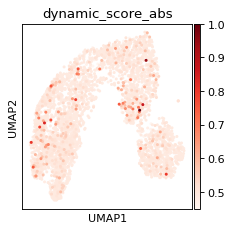

In [23]:
ad.obs["dynamic_score_abs"] = ad.obs["dynamic_score"].abs()
sc.pl.umap(ad, color="dynamic_score_abs", color_map="Reds", vmin=0.45)

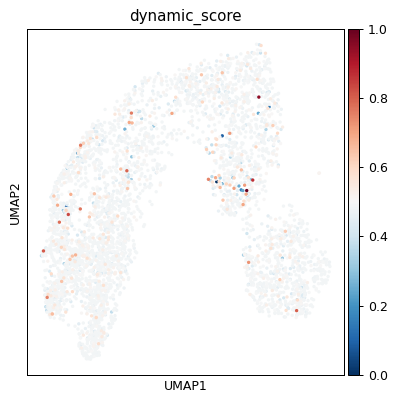

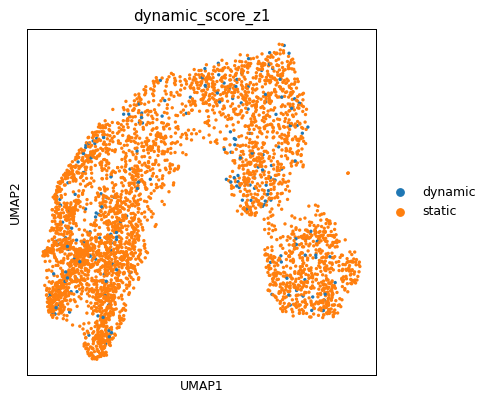

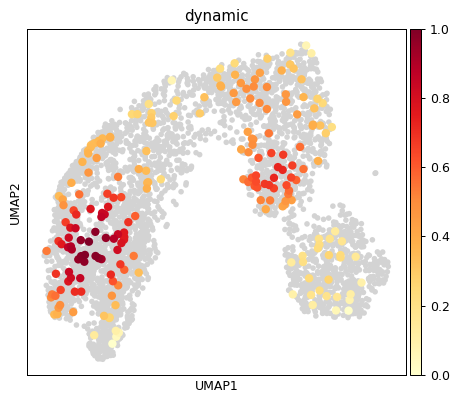

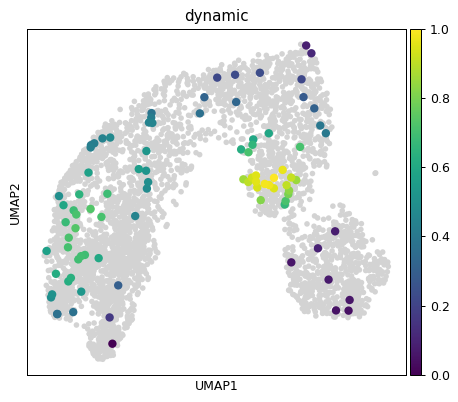

In [24]:
# contributions per newly added kernel
mb.pl.set_rcParams({"figure.figsize": [5, 5], "figure.dpi": 90})
sc.pl.umap(ad, color=["dynamic_score"], cmap="RdBu_r", sort_order=True)
sc.pl.umap(ad, color=["dynamic_score_z1"], cmap="RdBu_r", sort_order=True)

sc.tl.embedding_density(ad, basis="umap", groupby="dynamic_score_z1")
sc.pl.embedding_density(
    ad, basis="umap", key="umap_density_dynamic_score_z1", group="dynamic"
)  # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis="umap", groupby="dynamic_score_z2")
sc.pl.embedding_density(
    ad, basis="umap", key="umap_density_dynamic_score_z2", group="dynamic", color_map="viridis"
)  # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

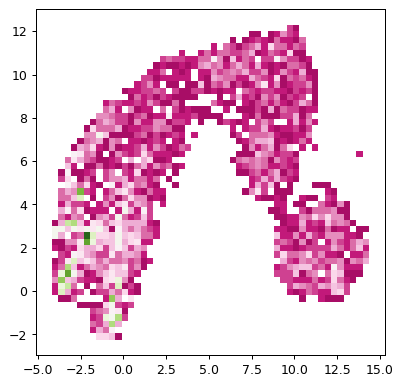

In [25]:
import seaborn as sns

umap = ad.obsm["X_umap"]
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap="PiYG")

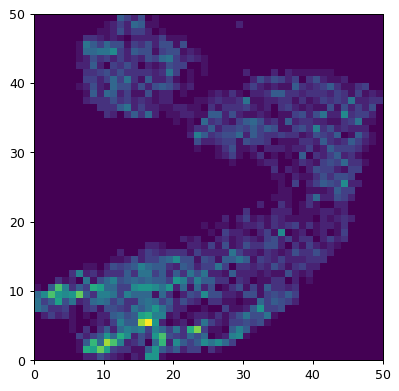

In [26]:
plt.pcolormesh(np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0])

In [27]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [28]:
x = umap[:, 1]  # array_txt[:,0]
y = umap[:, 1]  # array_txt[:,1]
z = ad.obs["dynamic_score"].values  # array_txt[:,2]

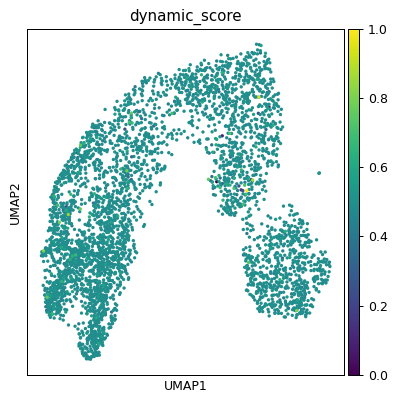

In [29]:
sc.pl.umap(ad, color="dynamic_score")

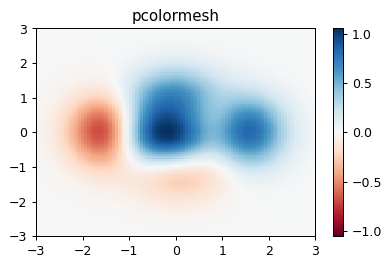

In [30]:
import matplotlib.pyplot as plt
import numpy as np

rcParams["figure.figsize"] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2.0 + x**5 + y**3) * np.exp(-(x**2) - y**2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap="RdBu", vmin=z_min, vmax=z_max)
ax.set_title("pcolormesh")
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [31]:
import itertools
import numpy as np


def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)

In [32]:
grid_dyn_score = grid(umap[:, 0], umap[:, 1], ad.obs["dynamic_score"], size_x=1, size_y=1)
grid_counts = grid(umap[:, 0], umap[:, 1], ad.obs["celltype"].cat.codes.values, size_x=1, size_y=1)

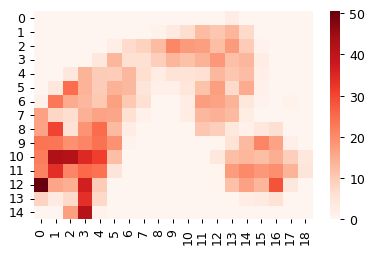

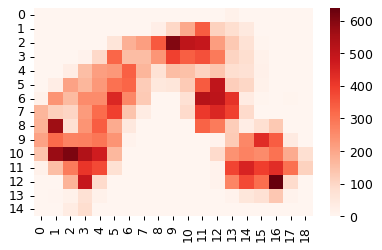

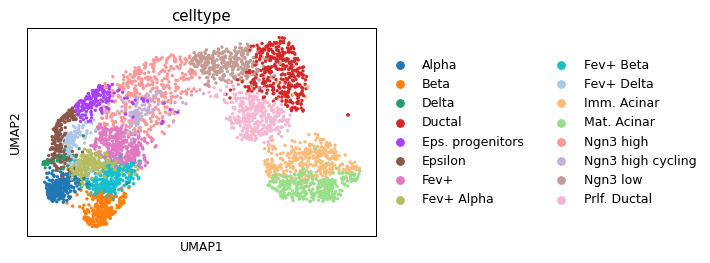

In [33]:
sns.heatmap(grid_dyn_score, cmap="Reds")
plt.show()
sns.heatmap(grid_counts, cmap="Reds")
plt.show()

sc.pl.umap(ad, color="celltype")

In [34]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()

In [35]:
model = model_by_logdynamic[True]

In [36]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense()  # (C, C)

In [37]:
# number of non_zero weights
len(G[G != 0])

36316

In [38]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [39]:
print("here...")

here...


In [40]:
ad

AnnData object with n_obs × n_vars = 4148 × 7200
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'modality', 'acc_score', 'acc_score_rank', 'chr', 'start', 'end', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'celltype_colors', 'neighbors', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectiviti

In [41]:
model = model.cuda()

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [43]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()

    umap = ad.obsm["X_umap"].copy()
    umap = np.sort(umap, 0)

    x = umap[:, 0]
    y = umap[:, 1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum, "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs["scale_countsum"] = model.datatype == "selex"
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print("here...")
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T

    # ad.layers['velocity'] = pred

    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()

    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']

    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True
here...
(128, 4148)
992092900000.0
here...
(128, 4148)
1204577200000.0
here...
(128, 4148)
1284266500000.0
here...
(128, 4148)
1180037300000.0
here...
(128, 4148)
1490843300000.0
here...
(128, 4148)
1153520600000.0
here...
(128, 4148)
1541420700000.0
here...
(128, 4148)
1288366000000.0
here...
(128, 4148)
1104948900000.0
here...
(128, 4148)
1335718700000.0
here...
(128, 4148)
1182732300000.0
here...
(128, 4148)
1200719400000.0
here...
(128, 4148)
1088891000000.0
here...
(128, 4148)
966658800000.0
here...
(128, 4148)
942856900000.0
here...
(128, 4148)
1542939000000.0
here...
(128, 4148)
1177951300000.0
here...
(128, 4148)
1238368900000.0
here...
(128, 4148)
1507240700000.0
here...
(128, 4148)
954634600000.0
here...
(128, 4148)
1438104800000.0
here...
(128, 4148)
850944300000.0
here...
(128, 4148)
900871360000.0
here...
(128, 4148)
1441167300000.0
here...
(128, 4148)
1447572900000.0
here...
(128, 4148)
1218416500000.0
here...
(128, 4148)
1215653600000.0
here...
(128, 4148)
119

In [44]:
import scvelo as scv

In [45]:
ad
ad.layers["velocity"] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [46]:
np.random.shuffle(binding_scores)
binding_scores

array([[1921778.9, 1705461.9, 1740023.2, ..., 2336158. , 2914210.5,
        3216438.5],
       [1924731.2, 1708099.2, 1742795. , ..., 2336234. , 2912806. ,
        3217170. ],
       [1923775.4, 1707252.4, 1742086.4, ..., 2335137. , 2911792. ,
        3215317.2],
       ...,
       [1920921.8, 1704752.2, 1739455.2, ..., 2331824.2, 2907168.5,
        3209852. ],
       [1930808. , 1713577.6, 1749307.8, ..., 2341404. , 2922228.8,
        3224495.5],
       [1923731.6, 1707165.2, 1741925.4, ..., 2334115. , 2909432.5,
        3214810. ]], dtype=float32)

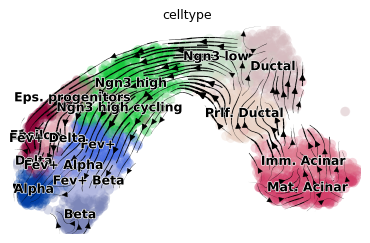

In [47]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color="celltype")
except Exception:
    print("sample too small.")

In [48]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

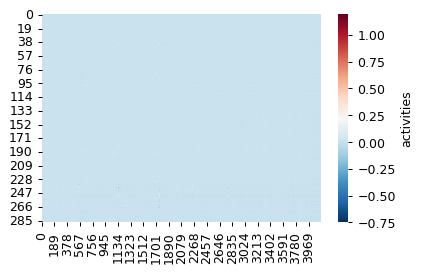

In [49]:
import seaborn as sns


act = model.get_log_activities().detach().cpu().squeeze(0)

sns.heatmap(act, cmap="RdBu_r", cbar_kws={"label": "activities"})

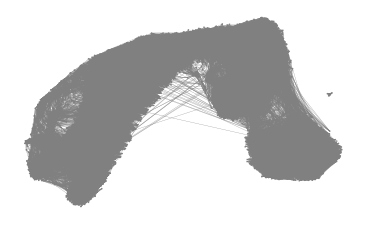

In [50]:
scv.pl.velocity_graph(rna)

In [51]:
# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [52]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [53]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [54]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 4148 × 14663
     obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch', 'velocity_self_transition'
     var: 'modality', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
     uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
     obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX', 'velocity_umap'
     layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced',

In [55]:
rna_sel = rna_sample  # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(4148, 14663)

In [56]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [57]:
import bindome as bd


bd.constants.ANNOTATIONS_DIRECTORY = "annotations"



anno = mb.datasets.archetypes_anno()

In [58]:
rna_sel.shape
anno.sort_values("Cluster_ID")

Cluster_ID          Name          DBD             Seed_motif  \
61            1          HD/1  homeodomain     LHX6_homeodomain_3   
72            2          HD/2  homeodomain          ALX3_MA0634.1   
79            3          HD/3  homeodomain    VENTX_homeodomain_2   
80            4          HD/4  homeodomain  BARX1_MOUSE.H11MO.0.C   
81            5          HD/5  homeodomain    BARX1_homeodomain_1   
..          ...           ...          ...                    ...   
163         282         PAX/2          PAX   PAX5_HUMAN.H11MO.0.A   
161         283  PAX-halfsite          PAX          Pax2_MA0067.1   
0           284           AHR         bHLH    AHR_HUMAN.H11MO.0.B   
105         285      KLF/SP/3         C2H2   KLF8_HUMAN.H11MO.0.C   
285         286        ZSCAN4         C2H2          ZSCAN4_C2H2_1   

     Total_width  Consensus_left  Consensus_right  Cluster_size  
61            12               0               12             2  
72            26               8               16           186  
79            21               3               20             1  
80            17               5               13            17  
81            21               2               18             6  
..           ...             ...              ...           ...  
163           24               4               21             3  
161            8               1                7             1  
0              9               2                8             3  
105            9               0                9             2  
285           15               1               14             2  

[286 rows x 8 columns]

False


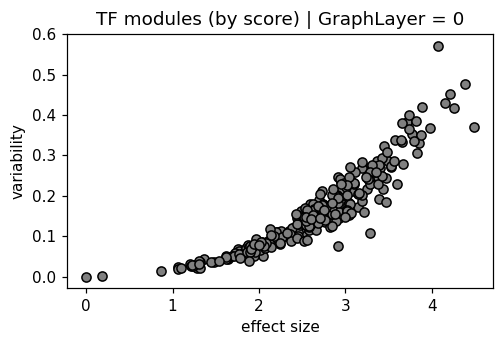

True


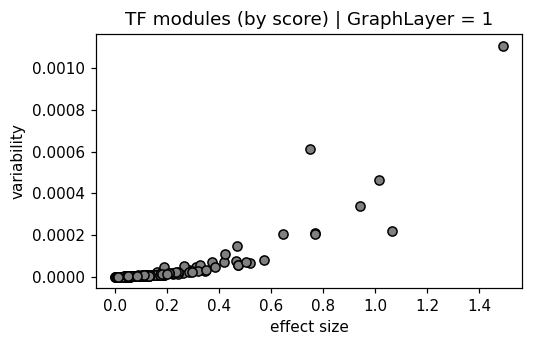

In [59]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm["mubind_activities"] = log_act

    mb.pl.set_rcParams({"figure.figsize": [5, 3], "figure.dpi": 110})
    delta = log_act.max(axis=0) - log_act.min(axis=0)
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color="gray", edgecolors="black")
    plt.xlabel("effect size")
    plt.ylabel("variability")
    plt.title("TF modules (by score) | GraphLayer = %i" % optimize_log_dynamic)
    plt.show()

In [60]:
# unique names for annotation
names = anno["Name"]  # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + "_%i" % added[name])
        added[name] += 1
anno["Name_unique"] = new_name

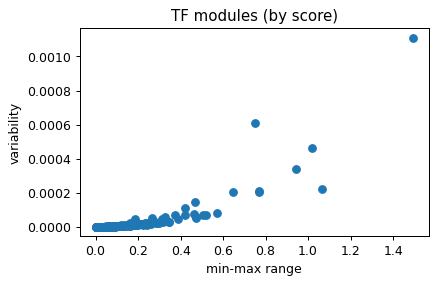

In [61]:
from scipy.stats import spearmanr


res = []

for optimize_log_dynamic in model_by_logdynamic:

    if not optimize_log_dynamic:
        continue


    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T

    log_act = pd.DataFrame(log_act.detach().cpu().numpy())

    # log_act.columns = anno['Seed_motif'][2]

    log_act.columns = ["intercept", "dinuc_bias"] + list(range(1, 287))

    log_act.index = ad.obs_names

    ad.obsm["mubind_activities"] = log_act


    mb.pl.set_rcParams({"figure.figsize": [5, 3], "figure.dpi": 90})

    delta = log_act.max(axis=0) - log_act.min(axis=0)

    var = log_act.var(axis=0)

    plt.scatter(delta, var)

    plt.xlabel("min-max range")

    plt.ylabel("variability")

    plt.title("TF modules (by score)")

    plt.show()


    for c in log_act:

        a = log_act[c]

        b = ad.obs["dynamic_score"].values

        # print(a.shape, b.shape)

        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))


res = pd.DataFrame(res, columns=["opt_log_dynamic", "archetype_id", "spearman", "p_val"])

In [62]:
# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ["max_effect", "variability"]
meta["name"] = ["intercept", "dinuc_bias"] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta["archetypes_name"] = meta["name"].map(anno.set_index("Cluster_ID")["Name_unique"])
meta["archetypes_name"] = np.where(pd.isnull(meta["archetypes_name"]), meta["name"], meta["archetypes_name"])

meta["archetypes_seed"] = meta["name"].map(anno.set_index("Cluster_ID")["Seed_motif"])
meta = meta.sort_values("max_effect", ascending=0)
meta

res = res.merge(meta, left_on="archetype_id", right_on="name")
res = res.sort_values("p_val", ascending=True)

In [63]:
name_by_filter_id = meta["archetypes_name"].to_dict()
# name_by_filter_id

## Observe general scores per case

<Axes: xlabel='max_effect', ylabel='archetypes_name'>

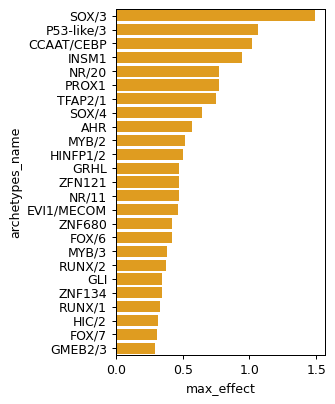

In [64]:
rcParams["figure.figsize"] = 3, 5
sns.barplot(
    data=res.sort_values("max_effect", ascending=False).head(25), x="max_effect", y="archetypes_name", color="orange"
)

In [65]:
res

opt_log_dynamic archetype_id  spearman         p_val  max_effect  \
181             True          180 -0.085108  4.026679e-08    0.121346   
33              True           32  0.057679  2.017768e-04    0.021953   
171             True          170  0.053759  5.326209e-04    0.036565   
244             True          243  0.051078  9.988277e-04    0.316506   
259             True          258  0.050797  1.065286e-03    0.472819   
..               ...          ...       ...           ...         ...   
70              True           69  0.000435  9.776783e-01    0.022655   
200             True          199 -0.000339  9.825946e-01    0.185973   
64              True           63  0.000326  9.832732e-01    0.072349   
188             True          187  0.000169  9.913384e-01    0.013637   
65              True           64 -0.000166  9.914805e-01    0.060838   

      variability name archetypes_name        archetypes_seed  
181  5.851416e-06  180           SIX/1   SIX1_HUMAN.H11MO.0.A  
33   3.194034e-07   32            NR/3   COT1_HUMAN.H11MO.0.C  
171  3.655862e-07  170          BCL6/2   BCL6_HUMAN.H11MO.0.A  
244  2.655000e-05  243           HIC/2   HIC1_HUMAN.H11MO.0.C  
259  5.695755e-05  258            GRHL            GRHL1_CP2_1  
..            ...  ...             ...                    ...  
70   1.215439e-07   69            MIES         MEIS1_MA0498.2  
200  9.662266e-06  199            MFZ1          MZF1_MA0057.1  
64   1.406672e-06   63    Ebox/CAGATGG  ATOH1_HUMAN.H11MO.0.B  
188  6.700983e-08  187           HIC/1            HIC2_C2H2_1  
65   1.111225e-06   64            HEN1   HEN1_HUMAN.H11MO.0.C  

[288 rows x 9 columns]

True
1
order None
0 out of 288...
10 out of 288...
break


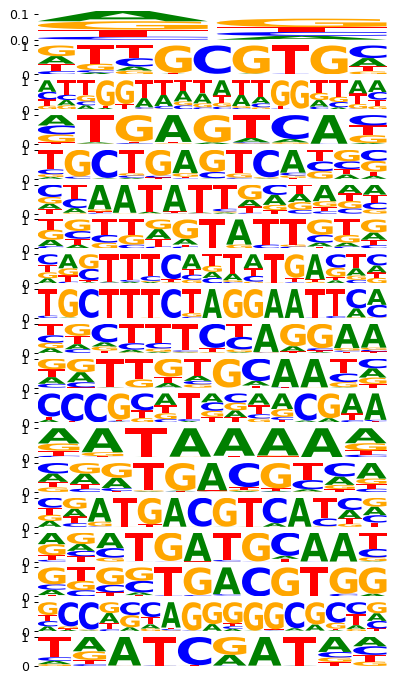

In [66]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({"figure.figsize": [5, 20], "figure.dpi": 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
# n_rows=len(res.head(20).index),

True
1
order Index([181,  33, 171, 244, 259,  10, 183, 246,  97, 216, 142, 271, 163, 238,
       108, 191, 135, 100,  23, 101],
      dtype='int64')
0 out of 288...
10 out of 288...


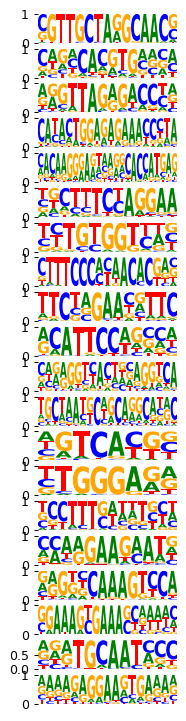

<Figure size 180x1800 with 0 Axes>

In [67]:
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    order=res.head(20).index,
)  # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [68]:
import resource

print("total GB used:", resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)

total GB used: 11.581188


In [69]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')

In [70]:
rna_sel.obsm["X_umap"] = ad.obsm["X_umap"]

In [71]:
def find_varname(ad, k, shuffle=False):
    if not shuffle:
        return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]
    else:
        ad_sel = ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]
        return pd.Series(ad.var_names).sample(ad_sel.shape[0]).values

In [72]:
from scipy.stats import spearmanr, pearsonr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [73]:
all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm["log_activities"] = log_act
    ad.obsm["log_activities"].columns = ["intercept", "dinuc_bias"] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm["log_activities"].iloc[:, 2:]:
        log_act = ad.obsm["log_activities"][k].values
        names = set()
        clu_sel = clu[clu["Cluster_ID"] == k]["Motif"]
        for g in clu_sel:
            names.add(g.split("_")[0].split(".")[0].split("+")[0].upper())
        for g in anno[anno["Cluster_ID"] == k]["Seed_motif"]:
            names.add(g.split("_")[0].split(".")[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap="Reds")

False
True


In [74]:

def get_act_gene_corr(model_by_logdynamic, shuffle=False, random_state=0):
    print('association between motif activities and related TF targets (shuffle = %i)' % shuffle)
    res = []
    # print(len(all_targets))

    rna_sel_df = rna_sel.to_df()

    for optimize_log_dynamic in model_by_logdynamic:
        print('use GraphLayer = %i' % optimize_log_dynamic)
        model = model_by_logdynamic[optimize_log_dynamic]

        log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
        log_act = pd.DataFrame(log_act.detach().cpu().numpy())
        log_act.index = ad.obs_names

        ad.obsm['log_activities'] = log_act
        ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

        # if shuffle:
        #     random_cols = ad.obsm['log_activities'].iloc[:,2:].columns.values
        #     np.random.shuffle(random_cols)
        #     # random_cols
        
        for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
            next_log_act = ad.obsm['log_activities'][k].values

            # if shuffle:
            #     next_log_act = ad.obsm['log_activities'][random_cols[ki]].values
            
            # print(ki)
            # if ki % 30 == 0:
            #     print(ki)
            names = set()
            clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
            for g in clu_sel:
                names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
            for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
                names.add(g.split('_')[0].split('.')[0])
            # print(k, names)
            next_targets = set()
            for name in names:
                target = find_varname(rna_sel, name, shuffle=shuffle)
                # print(name, target)
                for t in target:
                    next_targets.add(t)

            # for t in all_targets:
            for t in set(all_targets).intersection(next_targets):
                gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
                assert gex.shape[1] == 1
                gex = gex.flatten()
                # print(next_log_act.shape, gex.shape)
                # print(t, pearsonr(next_log_act, gex))
                res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                        list(spearmanr(next_log_act, gex)))
                
    res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

    # p-values
    res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
    res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])
    
    # p-val adjust
    from statsmodels.stats.multitest import fdrcorrection
    res['p_adj'] = fdrcorrection(res['p_val'])[1]
    return res


In [75]:
res = get_act_gene_corr(model_by_logdynamic)
shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i) for i in range(50)]

association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLa

In [76]:
table = []
for use_graph in [False, True]:
    for thr in range(1, 10):
        sel = res[res['opt_log_dynamic'] == use_graph]
        next_thr = 10 ** (-thr)
        n_pos = sel[sel['p_adj'] < next_thr].shape[0]
        n_neg = [s[(s['p_adj'] < next_thr) & (s['opt_log_dynamic'] == use_graph)].shape[0] for s in shuffled]
        # print(next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg))
        table.append([next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg), use_graph])
table = pd.DataFrame(table, columns=['p_adj_thr', 'n_pos', 'mu', 'sigma', 'zscore', 'graph_layer'])
table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore')

p_adj_thr    1.000000e-09  1.000000e-08  1.000000e-07  1.000000e-06  \
graph_layer                                                           
False           16.050467     18.507551     20.865115     22.623622   
True            18.958700     21.972552     23.170113     23.048353   

p_adj_thr    1.000000e-05  1.000000e-04  1.000000e-03  1.000000e-02  \
graph_layer                                                           
False           23.651633     24.457788     30.730947     39.531691   
True            24.148250     28.951415     36.071968     43.658257   

p_adj_thr    1.000000e-01  
graph_layer                
False           56.266204  
True            52.381155

<Axes: xlabel='p_adj_thr', ylabel='graph_layer'>

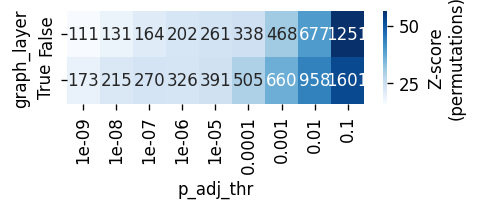

In [77]:
rcParams['figure.figsize'] = 4, 1
rcParams['figure.dpi'] = 120
hm = table.pivot(index='graph_layer', columns='p_adj_thr', values='n_pos').fillna(0)
z = table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore').fillna(0)
sns.heatmap(z, annot=hm, fmt='', cmap='Blues', # vmin=0, vmax=5,
            cbar_kws={'label': 'Z-score\n(permutations)'})

In [78]:
genes_by_module_name = (
    res.groupby(["module_name"])["gene_name"].apply(lambda grp: list(grp.value_counts().index)).to_dict()

)
# genes_by_module_name

In [79]:
res.sort_values("p_adj")

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
4602         51             True            52    Dbpht2     True -0.262511   
8789        280             True           281      Pax6     True -0.253239   
8519        247             True           248     Sparc     True  0.250501   
4005        247            False           248      Gars     True -0.249815   
8402        247             True           248      Gars     True -0.235877   
...         ...              ...           ...       ...      ...       ...   
8388        247             True           248     Armh4     True -0.000018   
6882         69             True            70     Ints1     True  0.000016   
7446         69             True            70    Tubb4b     True -0.000014   
4760         69             True            70     Ostf1     True -0.000008   
2226         69            False            70    Ptger1     True  0.000002   

             p_val module_name         p_adj  
4602  2.456352e-66  CCAAT/CEBP  2.160116e-62  
8789  1.041645e-61       PAX/1  4.580112e-58  
8519  2.229506e-60       NR/20  6.535426e-57  
4005  4.779171e-60       NR/20  1.050701e-56  
8402  1.516651e-53       NR/20  2.667485e-50  
...            ...         ...           ...  
8388  9.990890e-01       NR/20  9.995013e-01  
6882  9.991603e-01       TBX/1  9.995013e-01  
7446  9.992759e-01       TBX/1  9.995032e-01  
4760  9.995653e-01       TBX/1  9.996790e-01  
2226  9.998726e-01       TBX/1  9.998726e-01  

[8794 rows x 9 columns]

In [80]:
res["k"] = res["gene_name"] + "_" + res["archetype_id"].astype(str)
df2 = res.pivot(index="k", columns="opt_log_dynamic", values="spearman")
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [81]:
df2

opt_log_dynamic     False     True 
k                                  
A3galt2_70      -0.000421  0.016349
Aar2_248        -0.005109 -0.009799
Aard_248        -0.064836 -0.090566
Aars2_248        0.030377  0.002250
Aars_248         0.037296  0.017259
...                   ...       ...
mt-Nd3_70        0.043213  0.054751
mt-Nd4_70        0.080585  0.090479
mt-Nd4l_70       0.049005  0.028717
mt-Nd5_70        0.082189  0.066180
mt-Nd6_70        0.040519  0.007349

[4397 rows x 2 columns]

In [82]:
mb.pl.set_rcParams({"figure.figsize": [5, 4], "figure.dpi": 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)

In [83]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [84]:
# res['arch_name'] = name_by_filter_id

In [85]:
res

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
0             1            False             2      Usp7     True  0.016616   
1             1            False             2      Fen1     True -0.033387   
2             1            False             2     Psen2     True -0.023346   
3             1            False             2    Arxes2     True -0.014711   
4             1            False             2      Ten1     True  0.013821   
...         ...              ...           ...       ...      ...       ...   
8789        280             True           281      Pax6     True -0.253239   
8790        280             True           281   Pax6os1     True -0.161616   
8791        282             True           283      Pax2     True  0.010454   
8792        283             True           284       Ahr     True  0.016311   
8793        284             True           285      Klf8     True -0.001669   

             p_val   module_name         p_adj            k  
0     2.846513e-01          HD/2  4.730203e-01       Usp7_2  
1     3.153832e-02          HD/2  9.823368e-02       Fen1_2  
2     1.327470e-01          HD/2  2.830843e-01      Psen2_2  
3     3.435393e-01          HD/2  5.364106e-01     Arxes2_2  
4     3.734946e-01          HD/2  5.672325e-01       Ten1_2  
...            ...           ...           ...          ...  
8789  1.041645e-61         PAX/1  4.580112e-58     Pax6_281  
8790  1.129311e-25         PAX/1  1.873803e-23  Pax6os1_281  
8791  5.008692e-01  PAX-halfsite  6.816224e-01     Pax2_283  
8792  2.935866e-01           AHR  4.824515e-01      Ahr_284  
8793  9.143989e-01      KLF/SP/3  9.560265e-01     Klf8_285  

[8794 rows x 10 columns]

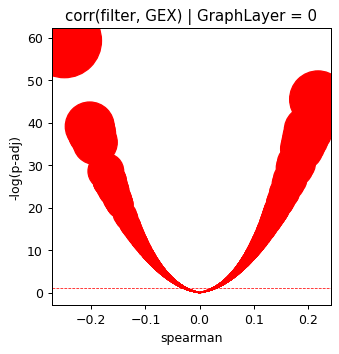

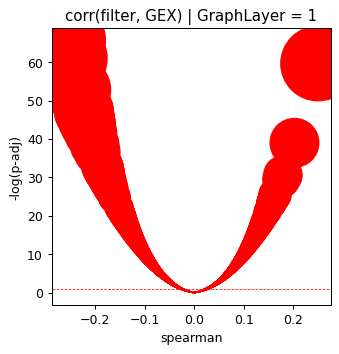

In [86]:
rcParams["figure.figsize"] = 4, 4
rcParams["figure.dpi"] = 90

for optimize_log_dynamic, grp in res.groupby("opt_log_dynamic"):
    grp["minus_log10_pval"] = -np.log10(grp["p_val"])
    grp = grp.sort_values("matched")
    plt.scatter(
        grp["spearman"],
        grp["minus_log10_pval"],
        s=np.power(grp["minus_log10_pval"], 2),
        color=np.where(grp["matched"], "red", "blue"),
    )
    plt.ylabel("-log(p-adj)")
    plt.xlabel("spearman")
    plt.title("corr(filter, GEX) | GraphLayer = %i" % optimize_log_dynamic)
    plt.axhline(1, ls="--", color="red", lw=0.6)
    plt.show()

In [87]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

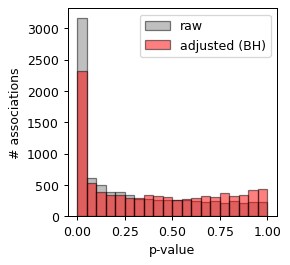

In [88]:
rcParams["figure.figsize"] = 3, 3
rcParams["figure.dpi"] = 90
plt.hist(res["p_val"], color="gray", bins=20, label="raw", alpha=0.5, edgecolor="black")
plt.hist(res["p_adj"], color="red", bins=20, label="adjusted (BH)", alpha=0.5, edgecolor="black")
plt.xlabel("p-value")
plt.legend()
plt.ylabel("# associations")

In [89]:
res[res["p_adj"] < 0.05]

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
8             1            False             2     Casp7     True -0.040429   
20            1            False             2      Pax4     True  0.062621   
21            1            False             2    Nkx6-1     True  0.077742   
33            6            False             7      Fen1     True -0.073266   
41            7            False             8       Arx     True -0.068667   
...         ...              ...           ...       ...      ...       ...   
8779        263             True           264     Ap2b1     True -0.084852   
8781        264             True           265      Ctcf     True  0.076174   
8782        265             True           266     Insm1     True  0.065165   
8789        280             True           281      Pax6     True -0.253239   
8790        280             True           281   Pax6os1     True -0.161616   

             p_val module_name         p_adj            k  
8     9.211802e-03        HD/2  3.736558e-02      Casp7_2  
20    5.440803e-05        HD/2  4.704663e-04       Pax4_2  
21    5.356512e-07        HD/2  7.418137e-06     Nkx6-1_2  
33    2.316461e-06        HD/7  2.786724e-05       Fen1_7  
41    9.583438e-06        HD/8  9.997243e-05        Arx_8  
...            ...         ...           ...          ...  
8779  4.422229e-08     TFAP2/1  7.565969e-07    Ap2b1_264  
8781  9.030204e-07        CTCF  1.197762e-05     Ctcf_265  
8782  2.667635e-05       INSM1  2.506323e-04    Insm1_266  
8789  1.041645e-61       PAX/1  4.580112e-58     Pax6_281  
8790  1.129311e-25       PAX/1  1.873803e-23  Pax6os1_281  

[2316 rows x 10 columns]

In [90]:
pval_thr = 1e-5
sel_genes = set(list(res[res["p_adj"] < pval_thr]["gene_name"]))

In [91]:
log_act = ad.obsm["log_activities"].copy()

In [92]:
cols_act = ["intercept", "dinuc_bias"] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [93]:
import anndata


ad_act = anndata.AnnData(log_act)

ad_act.obsm["X_umap"] = ad.obsm["X_umap"]

ad_act.obs = ad.obs

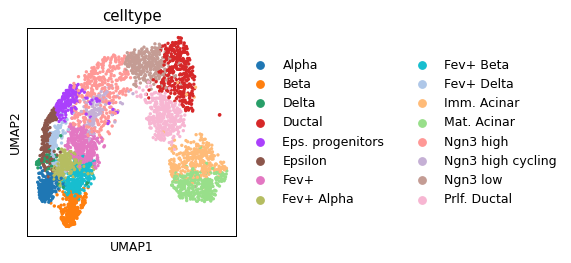

In [94]:
sc.pl.umap(ad_act, color="celltype")

Rank genes groups using the annotation

In [95]:
sc.tl.rank_genes_groups(ad_act, "celltype")
rkg_df = []
for ct in ad_act.obs["celltype"].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2["celltype"] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df["module_name"] = rkg_df["names"].map(anno.set_index("Cluster_ID")["Name"].to_dict())
rkg_df["module_name"] = np.where(~pd.isnull(rkg_df["module_name"]), rkg_df["module_name"], rkg_df["names"])
rkg_df.head()

Eps. progenitors
Imm. Acinar
Alpha
Ngn3 high
Prlf. Ductal
Epsilon
Fev+
Ngn3 low
Fev+ Alpha
Fev+ Delta
Ngn3 high cycling
Beta
Ductal
Fev+ Beta
Delta
Mat. Acinar


names    scores  logfoldchanges         pvals     pvals_adj  \
0       SIX/1  5.979688             NaN  3.360914e-09  3.024823e-08   
1     SPDEF/1  5.624515             NaN  3.646747e-08  3.000752e-07   
2         GLI  5.513223             NaN  8.842945e-08  6.883157e-07   
3      NFAT/1  5.450161             NaN  7.894709e-08  6.315767e-07   
4  EVI1/MECOM  5.347757             NaN  2.010762e-07  1.447749e-06   

           celltype module_name  
0  Eps. progenitors       SIX/1  
1  Eps. progenitors     SPDEF/1  
2  Eps. progenitors         GLI  
3  Eps. progenitors      NFAT/1  
4  Eps. progenitors  EVI1/MECOM

Get top modules

In [96]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index("names")["module_name"].to_dict())

In [97]:
sc.tl.rank_genes_groups(ad_act, "celltype")

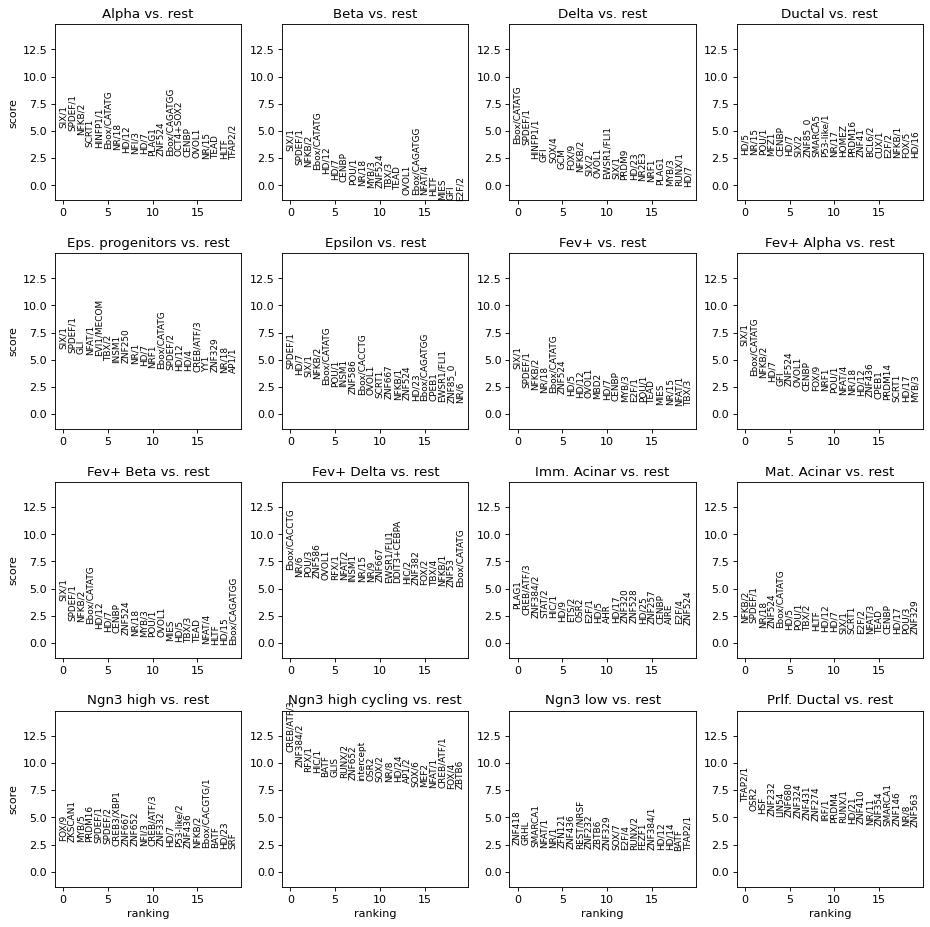

In [98]:
rcParams["figure.figsize"] = 3.5, 3.5
rcParams["figure.dpi"] = 80
sc.pl.rank_genes_groups(ad_act)

In [99]:
set(res[(res["p_adj"] < 1e-5)]["k"])

{'Aard_248',
 'Acot1_32',
 'Acot1_70',
 'Actb_70',
 'Actg1_70',
 'Adamts16_70',
 'Adamts1_70',
 'Adamts9_70',
 'Adamtsl1_70',
 'Adarb1_248',
 'Akt3_70',
 'Amotl2_70',
 'Ap2a1_264',
 'Ap2b1_264',
 'Araf_248',
 'Arc_248',
 'Arf1_248',
 'Arf3_248',
 'Arf5_248',
 'Arfgef1_248',
 'Arfgef3_248',
 'Arg1_248',
 'Arhgap11a_248',
 'Arhgap18_248',
 'Arhgap19_248',
 'Arhgap21_248',
 'Arhgap24_248',
 'Arhgap26_248',
 'Arhgap28_248',
 'Arhgap36_248',
 'Arhgap42_248',
 'Arhgap6_248',
 'Arhgef10l_248',
 'Arhgef11_248',
 'Arhgef12_248',
 'Arhgef19_248',
 'Arhgef26_248',
 'Arhgef39_248',
 'Arhgef5_248',
 'Arhgef9_248',
 'Arid1b_248',
 'Arid4b_248',
 'Arih1_248',
 'Arl3_248',
 'Arl4a_248',
 'Arl4c_248',
 'Arl6ip1_248',
 'Arl6ip4_248',
 'Arl8a_248',
 'Armc4_248',
 'Armc8_248',
 'Armc9_248',
 'Armh3_248',
 'Arpc5_248',
 'Arpp19_248',
 'Arx_248',
 'Atad2_70',
 'Atf3_70',
 'Atf7ip_50',
 'Atic_70',
 'Atp1a2_70',
 'Atp2a2_70',
 'Atp2b2_70',
 'Atp5l_70',
 'Atp5md_70',
 'Atp6v0b_70',
 'Atp6v0c_70',
 'Atp6v0d1_70

In [100]:
res[res["module_name"].str.contains("HD")].sort_values("p_adj")

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
21            1            False             2    Nkx6-1     True  0.077742   
3898        203            False           204      Irx2     True -0.073541   
33            6            False             7      Fen1     True -0.073266   
4419          1             True             2      Isl1     True -0.071139   
4421          1             True             2     Lmx1b     True  0.070839   
...         ...              ...           ...       ...      ...       ...   
8295        203             True           204      Irx2     True  0.001463   
3903        209            False           210    Hmbox1     True -0.001186   
4408          1             True             2      Men1     True -0.001059   
4406          1             True             2      Gbx1     True -0.000674   
32            1            False             2    Pou6f2     True -0.000217   

             p_val module_name     p_adj           k  
21    5.356512e-07        HD/2  0.000007    Nkx6-1_2  
3898  2.122596e-06       HD/23  0.000026    Irx2_204  
33    2.316461e-06        HD/7  0.000028      Fen1_7  
4419  4.515096e-06        HD/2  0.000051      Isl1_2  
4421  4.953960e-06        HD/2  0.000055     Lmx1b_2  
...            ...         ...       ...         ...  
8295  9.249364e-01       HD/23  0.962135    Irx2_204  
3903  9.391570e-01       HD/25  0.970841  Hmbox1_210  
4408  9.456555e-01        HD/2  0.972803      Men1_2  
4406  9.653987e-01        HD/2  0.982038      Gbx1_2  
32    9.888425e-01        HD/2  0.994609    Pou6f2_2  

[116 rows x 10 columns]

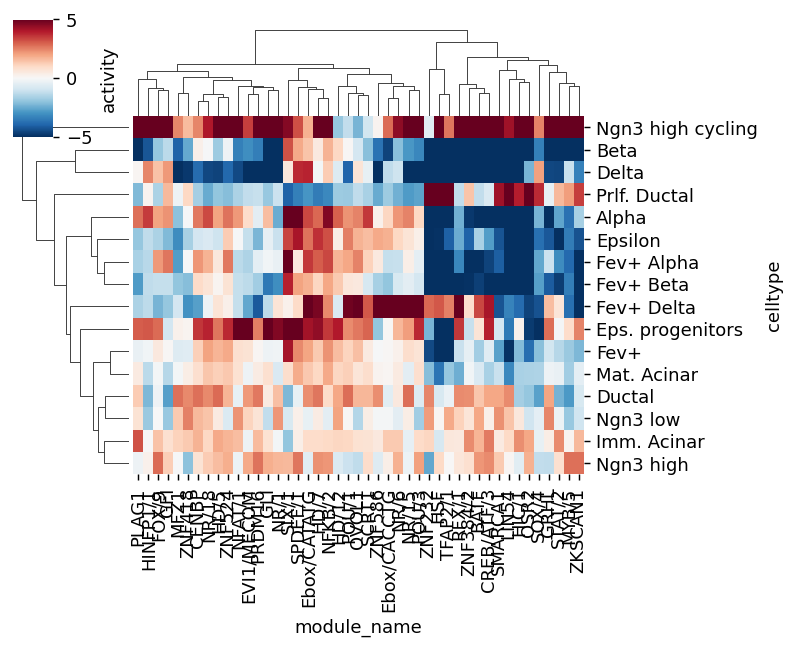

In [101]:
mod_names_best = set(rkg_df.sort_values("scores", ascending=False).groupby("celltype").head(5)["module_name"])
best = rkg_df[rkg_df["module_name"].isin(mod_names_best)]
rcParams["figure.dpi"] = 130
sns.clustermap(
    best.pivot(index="celltype", columns="module_name", values="scores"),
    cbar_kws={"label": "activity"},
    cmap="RdBu_r",
    vmin=-5,
    vmax=5,
    figsize=[6.2, 5],
    # dpi=100,
    xticklabels=True,
)

In [102]:
rna_tfs = rna_sel.to_df()[list(set(res["gene_name"]))]
rna_tfs["celltype"] = rna_sel.obs["celltype"]
mean_tfs = rna_tfs.groupby("celltype").mean()

act_tfs_df = ad_act.to_df()
act_tfs_df["celltype"] = ad_act.obs["celltype"]
mean_act_tf = act_tfs_df.groupby("celltype").mean()

In [103]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2, mean_act_tf.index[np.argmax(mean_act_tf[c1])]] + list(pearsonr(a, b)))

corr = pd.DataFrame(corr_celltype, columns=["module_name", "gene_name", "cell_type", "pearsonr", "p_val"])
corr = corr.sort_values("pearsonr", ascending=False)

0 288
50 288
100 288
150 288
200 288
250 288


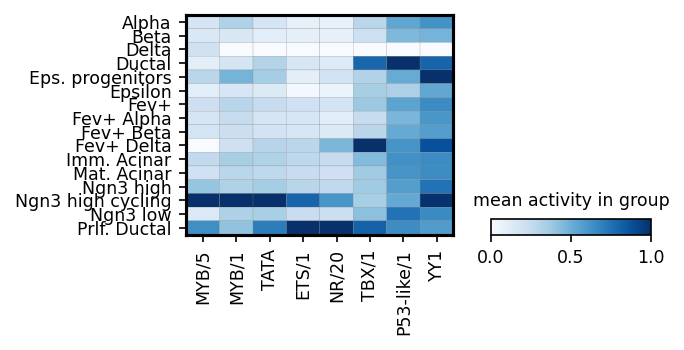

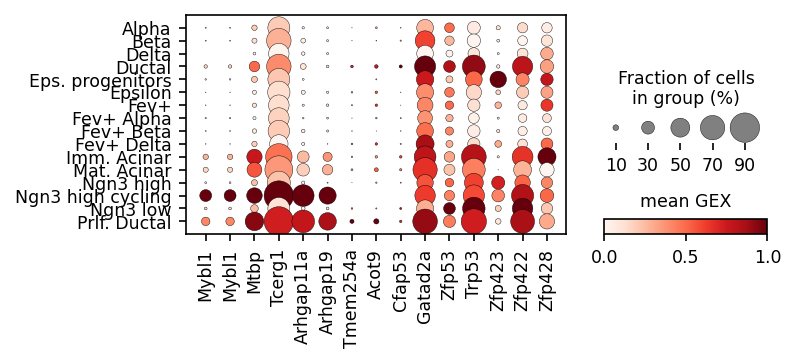

In [104]:
rcParams['figure.dpi'] = 150
# activators
module_names = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.9],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              standard_scale='var',
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.9])



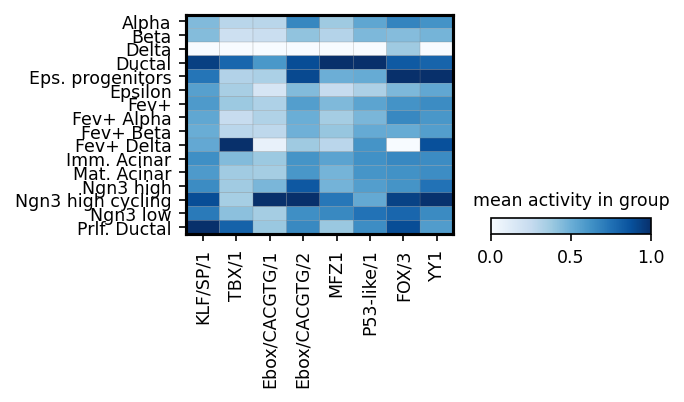

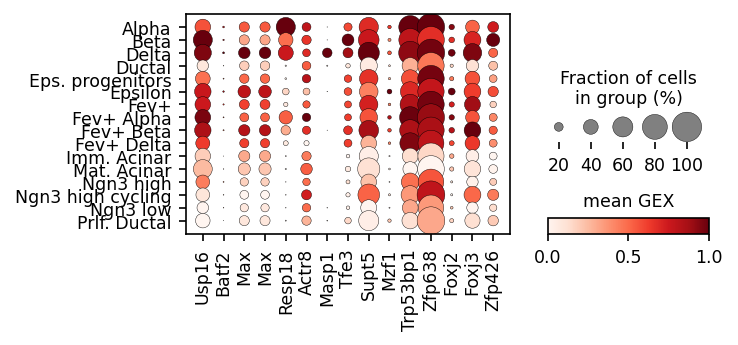

In [105]:
# repressors
module_names = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.9],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              standard_scale='var',
              var_names=gene_names,
              figsize=[4.5, 1.9])



In [106]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

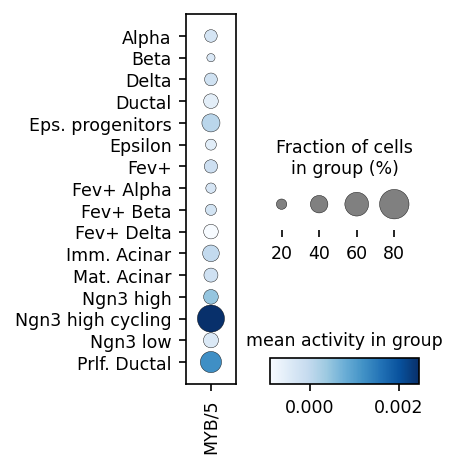

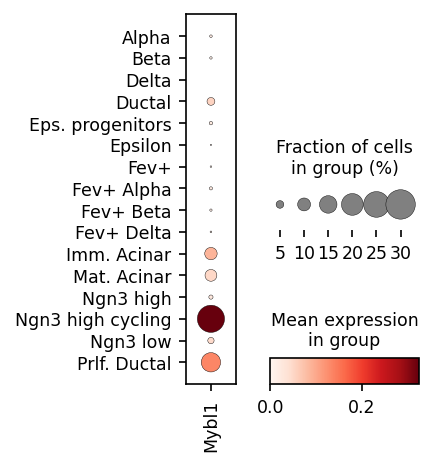

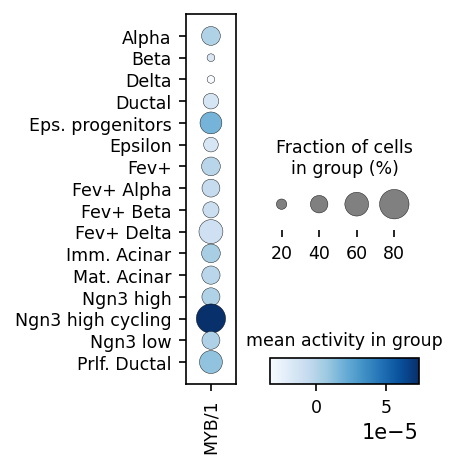

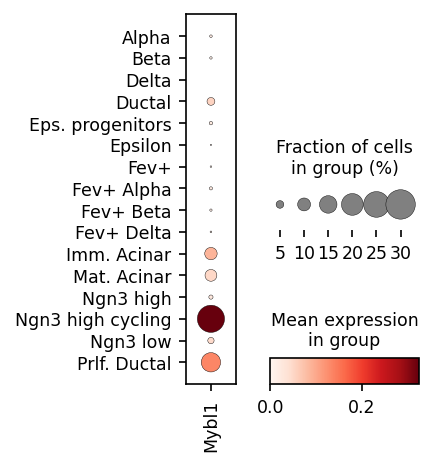

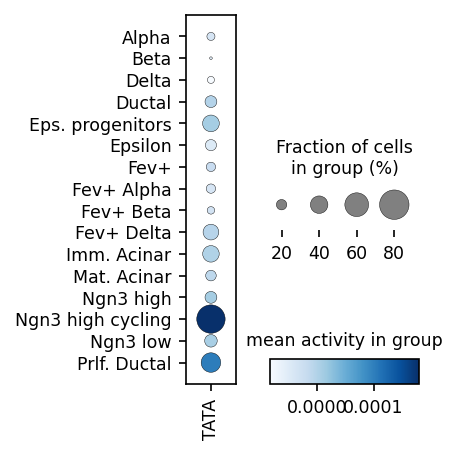

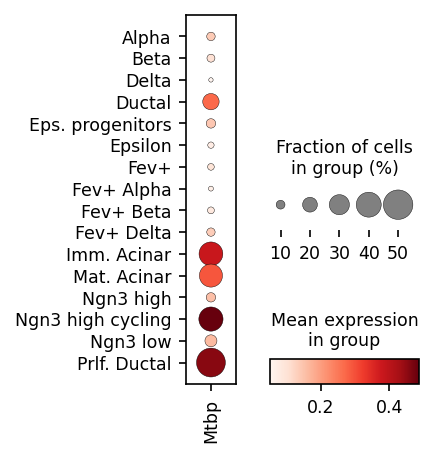

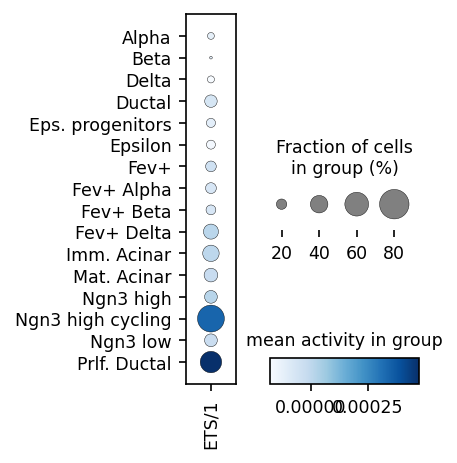

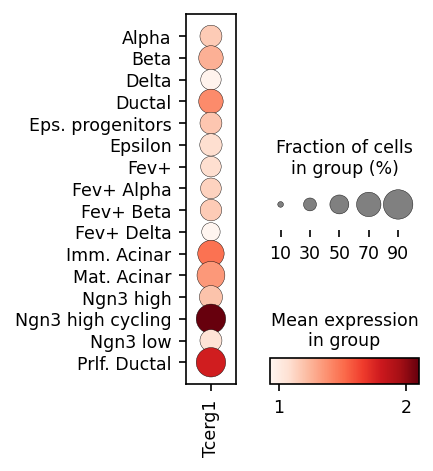

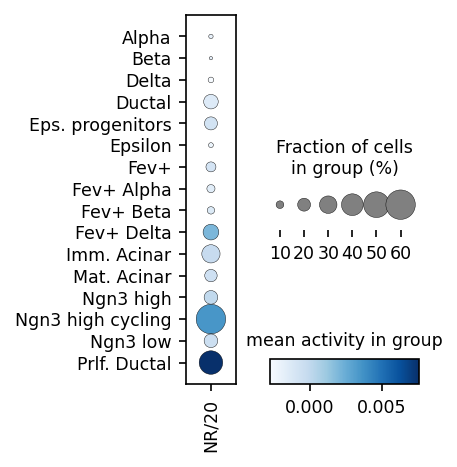

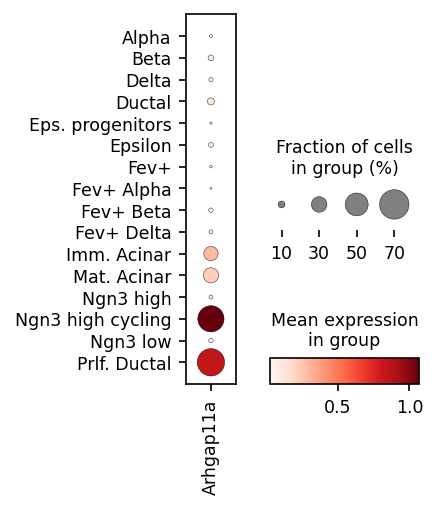

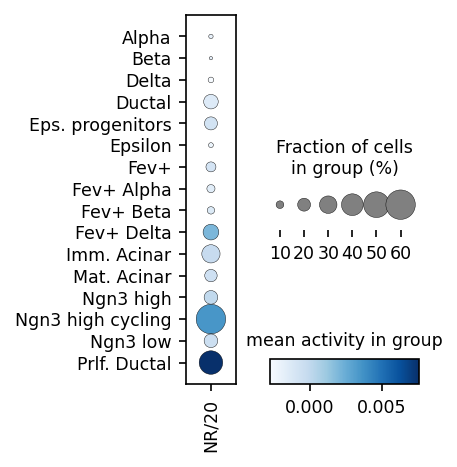

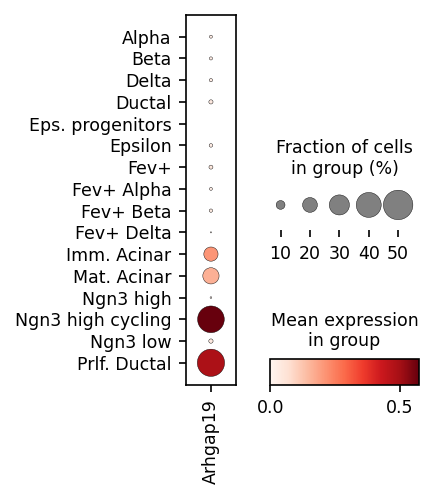

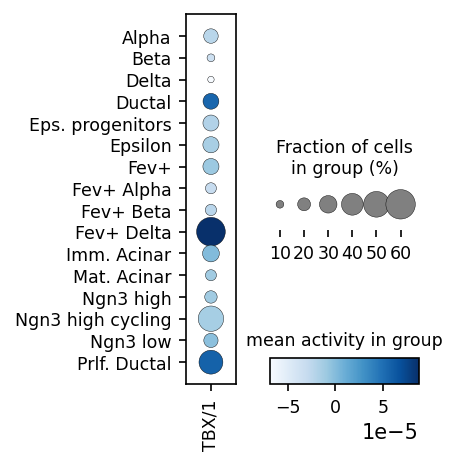

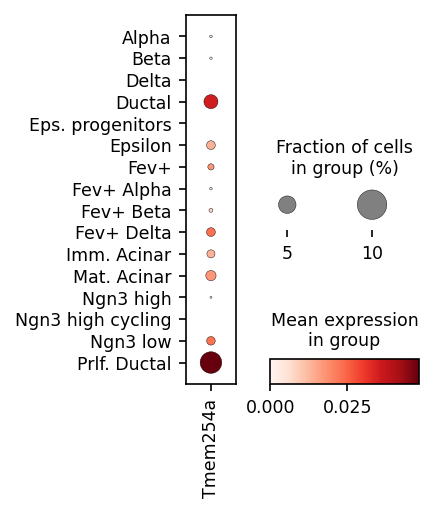

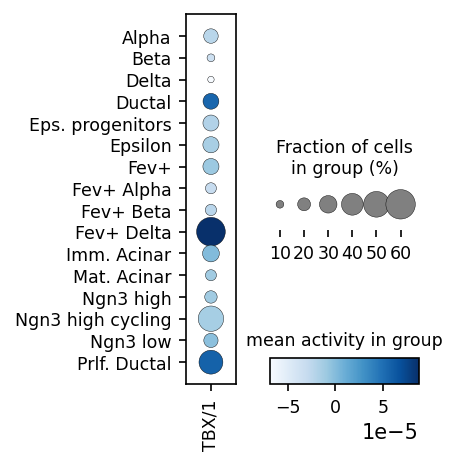

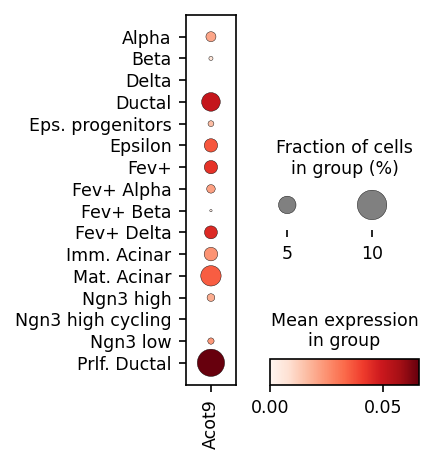

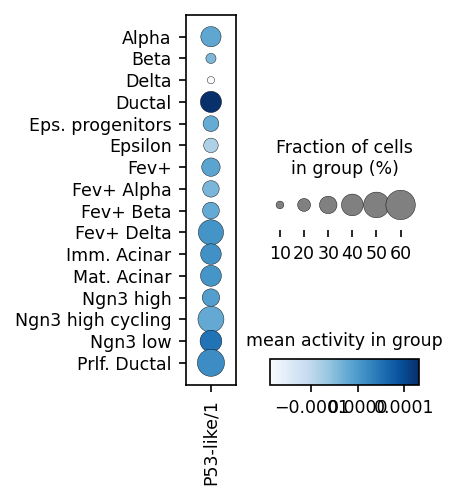

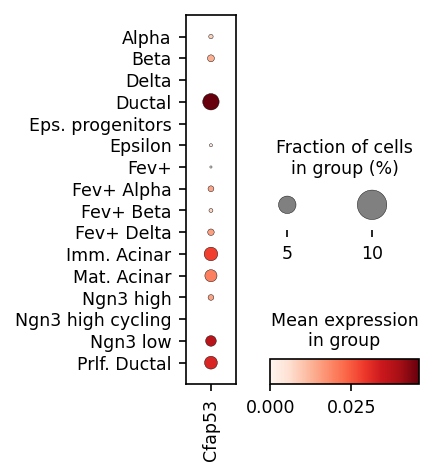

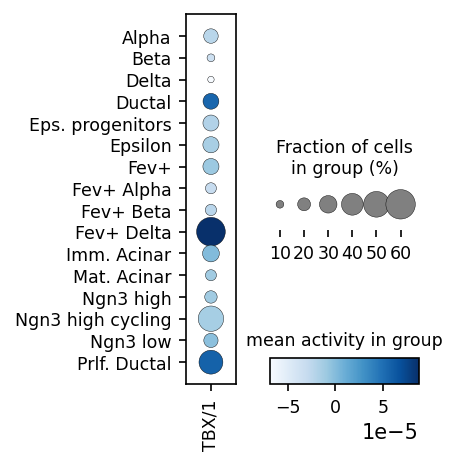

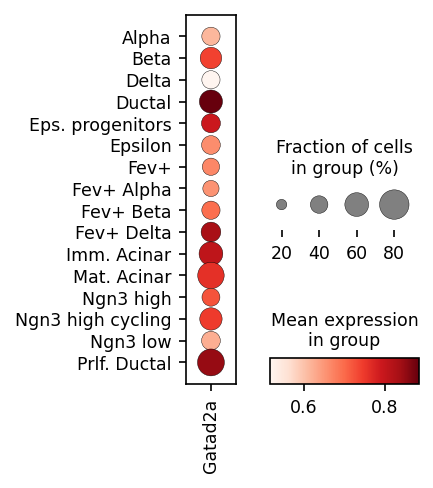

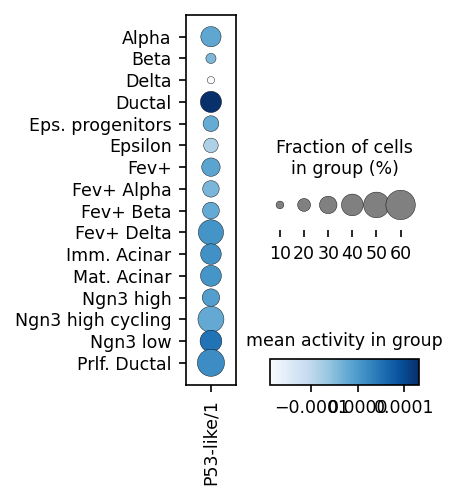

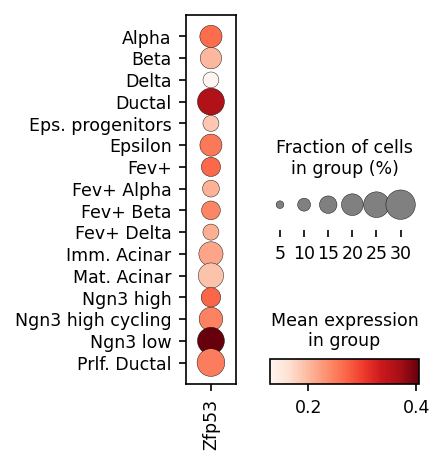

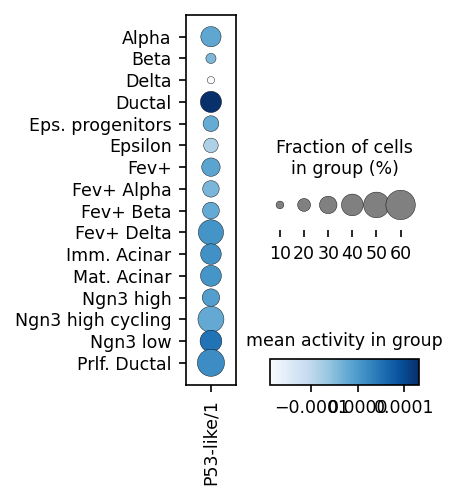

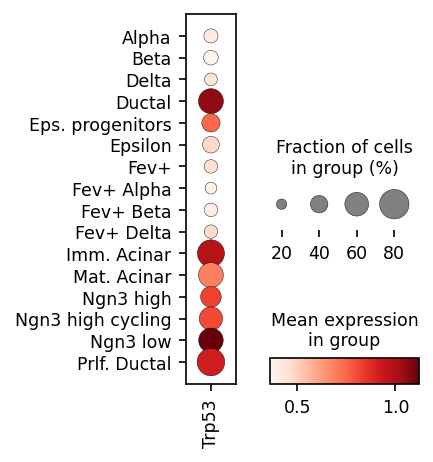

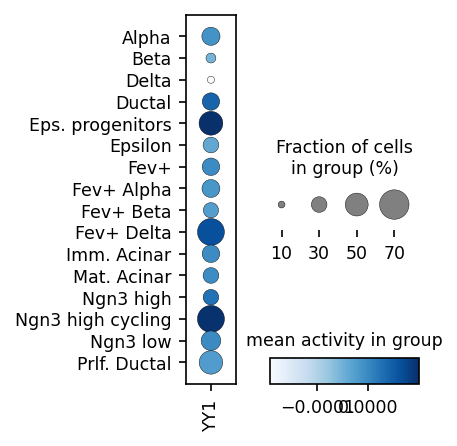

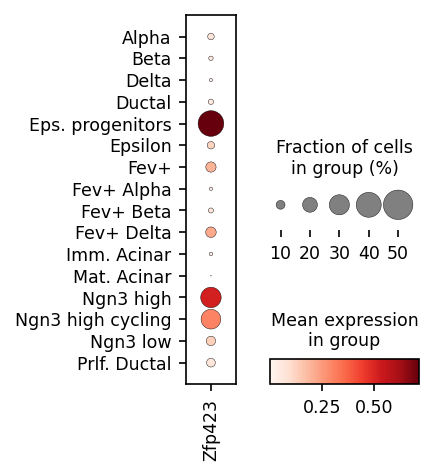

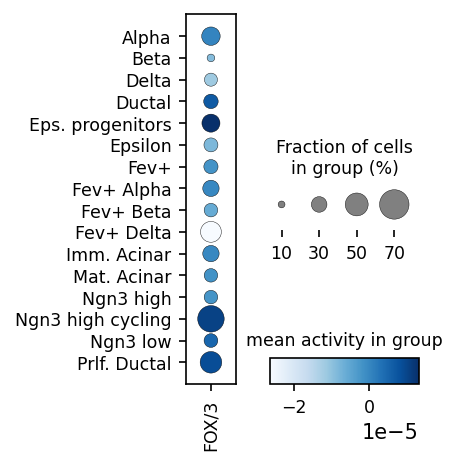

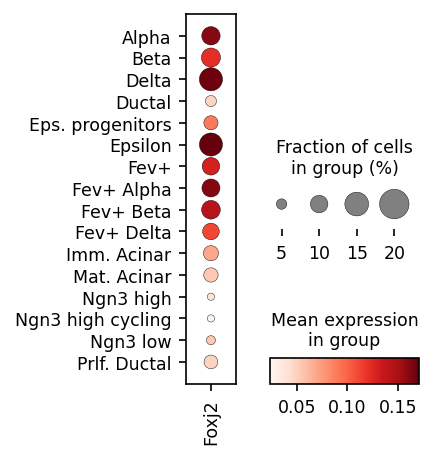

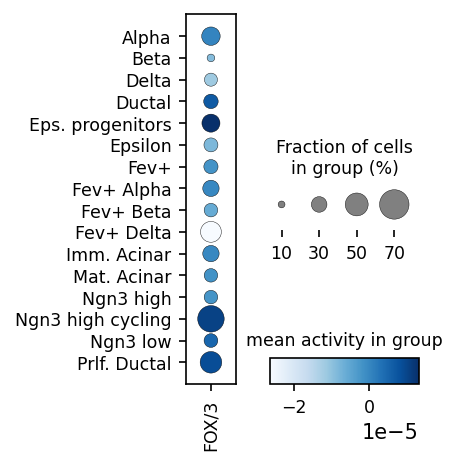

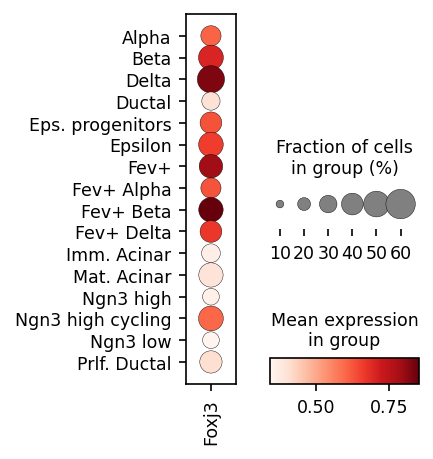

In [107]:
for ri, r in corr.sort_values("p_val").groupby("cell_type").head(3).iterrows():
    # ad_act.obs['HD/2'] = log_act['HD/2']
    sc.pl.dotplot(
        ad_act,
        groupby="celltype",
        cmap="Blues",
        var_names=r["module_name"],
        figsize=[2, 3.2],
        colorbar_title="mean activity in group",
    )
    sc.pl.dotplot(rna_sel, groupby="celltype", var_names=r["gene_name"], figsize=[2, 3.2])

## Filter activities versus graph activities

In [108]:
A = model.get_log_activities()
sum_A = A.abs().sum(axis=1).cpu().detach().numpy()
A = A.squeeze(0)
print(A.shape)

torch.Size([288, 4148])


In [109]:
# this function assesses the contributions of A on the graph
indices, contributions, max_eig = mb.tl.compute_contributions(A, C * D)

contributions_normalized = torch.abs(contributions) / max_eig
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=["index"])
print("Summary statistics of the normalized contributions: \n")
contributions_df.describe()

Summary statistics of the normalized contributions: 



index
count  288.000000
mean     0.300399
std      0.049388
min      0.149585
25%      0.270559
50%      0.299396
75%      0.329398
max      0.513186

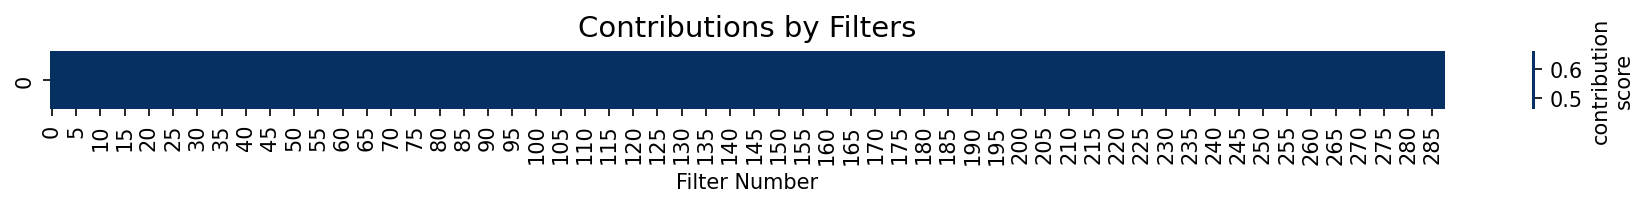

In [110]:
mb.pl.filter_contrib_heatmap(contributions_normalized)

Percentage of non-zero entries of the filter matrix A: 100.0 %
(288,) (288,)


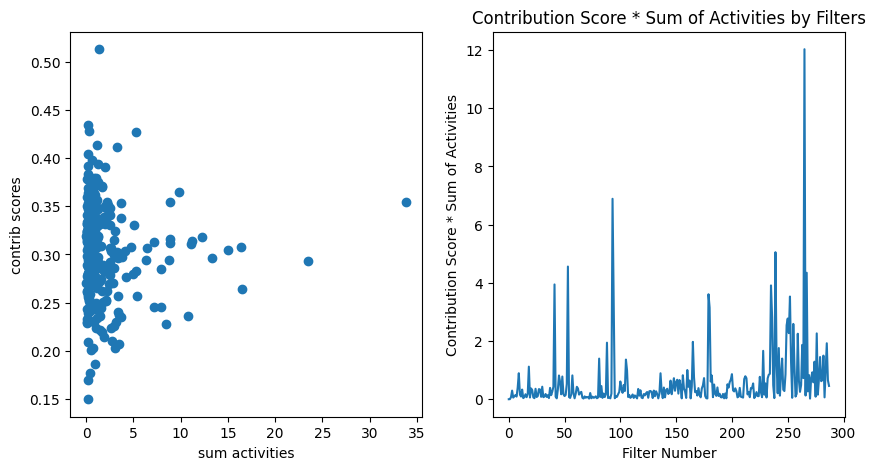

In [111]:
from matplotlib.pyplot import rcParams

rcParams["figure.dpi"] = 100
plt.figure(figsize=(10, 5))

print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")

mb.pl.filter_contrib_simple(contributions_normalized, A.cpu())

In [112]:
# normalize the data, and look at summary stats
sum_A_norm = sum_A / np.max(sum_A)
sum_A_df = pd.DataFrame(sum_A.T, columns=["sum_A"])
sum_A_df.describe()

sum_A
count  4148.000000
mean      0.134161
std       0.509002
min       0.006000
25%       0.031845
50%       0.059126
75%       0.106652
max      19.711349

In [113]:
contrib_arr = contributions_normalized.unsqueeze(dim=0).detach().numpy()
sum_A = A.cpu().abs().sum(axis=1).detach().numpy()
contrib = contrib_arr[0]

contrib_times_activities = contrib * sum_A
contrib_times_activities_norm = contrib_times_activities / np.max(contrib_times_activities)
contrib_times_activities_df = pd.DataFrame(contrib_times_activities, columns=["contribution_times_activities"])
contrib_times_activities_df.describe()

contribution_times_activities
count                     288.000000
mean                        0.580848
std                         1.114942
min                         0.000039
25%                         0.084503
50%                         0.244805
75%                         0.607406
max                        12.027171

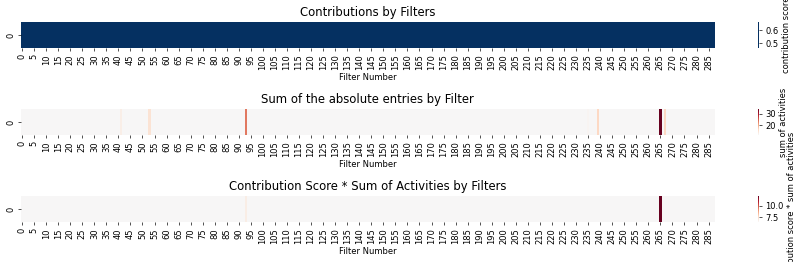

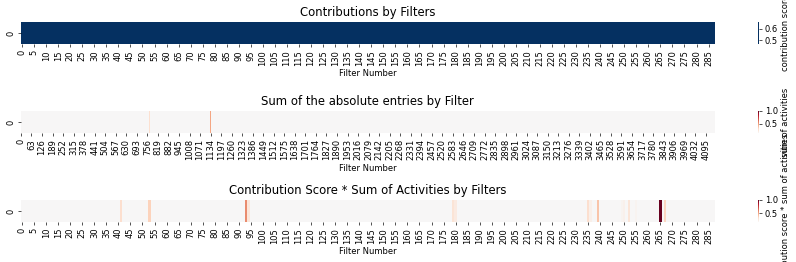

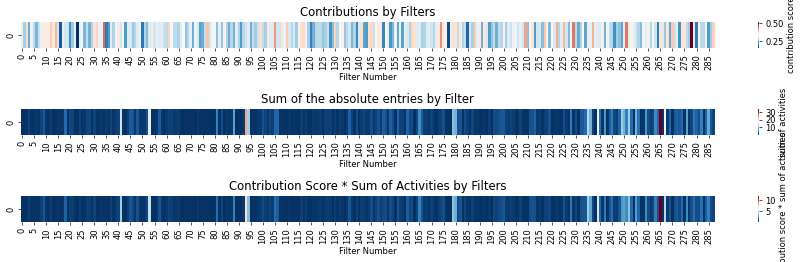

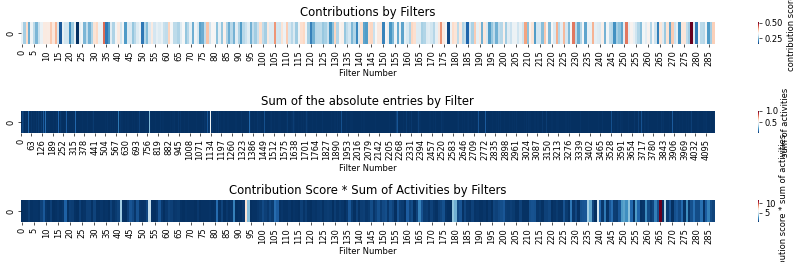

In [114]:
from matplotlib.pyplot import rcParams

rcParams["figure.dpi"] = 60

# unsqueeze the data to make it compatible with the heatmap function
sum_A_norm = sum_A_norm.reshape(1, -1)
contrib_times_activities = contrib_times_activities.reshape(1, -1)


# only plotting filters, that are within the top 25% of the maximum contribution score
mb.pl.contrib_heatmaps(
    contributions_normalized, sum_A.reshape(1, -1), contrib_times_activities, (0.66, 11.85, 6.49), (0.66, 11.85, 6.49)
)  # vmin values come from the describe() functions

# plotting top 25% of filters normalized
mb.pl.contrib_heatmaps(
    contributions_normalized,
    sum_A_norm,
    contrib_times_activities_norm.reshape(1, -1),
    vmins=(0.66, 0.14, 0.19),
    centers=(0.66, 0.14, 0.19),
)  # vmin values come from the describe() functions

# plotting all filter
mb.pl.contrib_heatmaps(contributions_normalized, sum_A.reshape(1, -1), contrib_times_activities)

# plotting all filters normalized
mb.pl.contrib_heatmaps(contributions_normalized, sum_A_norm, contrib_times_activities)

In [ ]:
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 135

ax = plt.subplot()
plt.scatter(res['graph_score'], res['spearman'], s=-np.log(res['p_adj'] + 1e-10))
plt.xlabel('Graph contribution * Sum activities')
plt.ylabel('TF activity [GEX, act] | -log(P)')


res['z'] = np.sqrt((res['graph_score'] ** 2) * (-np.log(res['p_adj'] + 1e-10)) ** 2)
res_sel = res.sort_values('z', ascending=False)

res_sel['k'] = res_sel['module_name'] + ':' + res_sel['gene_name']
res_sel = res_sel.drop_duplicates('module_name')

for ri, r in res_sel.head(10).iterrows():
    print(r['module_name'] + ':' + r['gene_name'], (r['graph_score'], r['spearman']))
    ax.annotate(r['module_name'] + ':' + r['gene_name'], (r['graph_score'], r['spearman']))
